In [1]:
import torch
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import sklearn.datasets
import time
import matplotlib.pyplot as plt
import numpy as np
import wandb
import copy
import quant_lib.Moons_MLP as mlp
import quant_lib.figure as figure
import torch.optim as optim
import torchvision.transforms as transforms


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def MLP2MoonsNet(bit_width=1):
    return mlp.MLP(num_classes=2,bit_width=bit_width)

In [3]:
def load_array(features, labels, batch_size, is_train=True):
    dataset = data.TensorDataset(features, labels)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

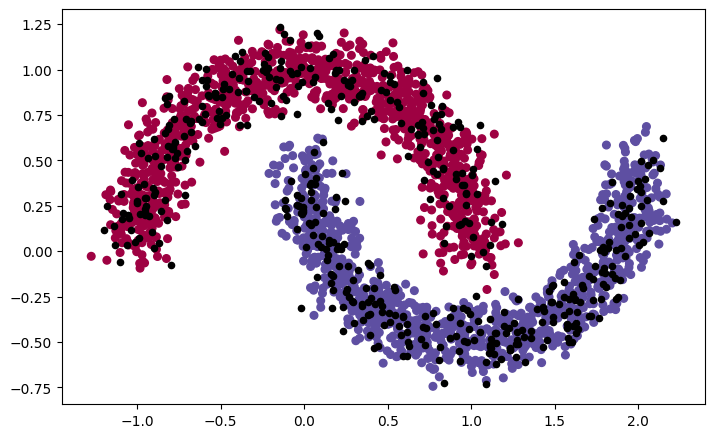

In [4]:
# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set hyperparameter
bit_width=1
EPOCH = 60
ANNEAL_EPOCH_AS = 30
ANNEAL_EPOCH_PQ = 10
pre_epoch = 0
BATCH_SIZE = 50
LR = 0.5
# ASkewSGD
DECAY_CONST=0.88
alpha = 0.2
# ProxQuant
reg_lambda = 5e-2

# Generate training and testing dataset
n_train = 2000
n_test = 500
n = n_train + n_test
X, Y = sklearn.datasets.make_moons(n_samples=n, noise=0.1, random_state=0)
X = torch.from_numpy(X).float()
Y = torch.from_numpy(Y).reshape(-1)
X_train, Y_train = X[:n_train], Y[:n_train]
X_test, Y_test = X[n_train:], Y[n_train:]
trainloader = load_array(X_train, Y_train, batch_size=BATCH_SIZE, is_train=True)
testloader = load_array(X_test, Y_test, batch_size=BATCH_SIZE, is_train=False)
# Define base net
base_net = MLP2MoonsNet(bit_width=bit_width).to(device)
# Define loss 
criterion = nn.CrossEntropyLoss()

figure.moons_plot(X_train, X_test, Y_train, Y_test, width=600)

In [5]:
def init(project_name, opt_name, batch_size, architecture, dataset_name, lr, alpha=None, reg_lambda=None):
    wandb.init(
        # set the wandb project where this run will be logged
        project=project_name,
        name=opt_name,
        # track hyperparameters and run metadata
        config={
            "batch_size": batch_size,
            "architecture": architecture,
            "dataset": dataset_name,
            "lr": lr,
            "alpha": alpha, 
            "reg_lambda": reg_lambda,
            "bit_width": base_net.bit_width
        },
    )
    net = copy.deepcopy(base_net)
    net.to(device)
    weights = [p for name, p in net.named_parameters() if 'bias' not in name]
    bias = [p for name, p in net.named_parameters() if 'bias' in name]
    parameters = [{"params": weights, "tag": "weights"}, {"params": bias, "tag": "bias"}]
    optimizer = optim.Adam(parameters, lr=lr, betas=(0.9, 0.999))
    return net, optimizer

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hokfong (hokfong-the-chinese-university-of-hong-kong). Use `wandb login --relogin` to force relogin



Epoch: 1
[Epoch:1, Iter:1] Loss: 0.687 | Acc: 48.000% 
[Epoch:1, Iter:2] Loss: 0.666 | Acc: 53.000% 
[Epoch:1, Iter:3] Loss: 0.558 | Acc: 64.667% 
[Epoch:1, Iter:4] Loss: 0.502 | Acc: 69.500% 
[Epoch:1, Iter:5] Loss: 0.448 | Acc: 74.000% 
[Epoch:1, Iter:6] Loss: 0.437 | Acc: 75.000% 
[Epoch:1, Iter:7] Loss: 0.411 | Acc: 77.143% 
[Epoch:1, Iter:8] Loss: 0.427 | Acc: 78.000% 
[Epoch:1, Iter:9] Loss: 0.400 | Acc: 79.778% 
[Epoch:1, Iter:10] Loss: 0.389 | Acc: 80.400% 
[Epoch:1, Iter:11] Loss: 0.396 | Acc: 80.545% 
[Epoch:1, Iter:12] Loss: 0.387 | Acc: 80.833% 
[Epoch:1, Iter:13] Loss: 0.375 | Acc: 81.385% 
[Epoch:1, Iter:14] Loss: 0.356 | Acc: 82.429% 
[Epoch:1, Iter:15] Loss: 0.340 | Acc: 83.333% 
[Epoch:1, Iter:16] Loss: 0.326 | Acc: 84.000% 
[Epoch:1, Iter:17] Loss: 0.317 | Acc: 84.588% 
[Epoch:1, Iter:18] Loss: 0.304 | Acc: 85.111% 
[Epoch:1, Iter:19] Loss: 0.291 | Acc: 85.789% 
[Epoch:1, Iter:20] Loss: 0.283 | Acc: 86.200% 
[Epoch:1, Iter:21] Loss: 0.274 | Acc: 86.571% 
[Epoch:1, It

accuracy,▆▇▇█▁▇██▆▇██████████████████████████████
quantized_accuracy,▆█▃▃▄▂▁▂▃▂▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂
quantized_test_accuracy,▇█▂▂▂▂▁▁▃▂▄▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂
quantized_test_loss,▅▁▄▄▆▆▄▃▆█▃▂▂▂▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅
test_accuracy,▆█▇█▁▇██▆██▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
test_loss,▃▂▂▁█▂▁▁▂▁▂▁▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
accuracy,100.00001
quantized_accuracy,43.45
quantized_test_accuracy,46.8
quantized_test_loss,6.07217
test_accuracy,99.60001


c:\Users\lenovo\Desktop\CUHK\Research-2025\exp\quant_lib\figure.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(net(torch.tensor(X_test, dtype=torch.float, device=device)), 1), 1
c:\Users\lenovo\Desktop\CUHK\Research-2025\exp\quant_lib\figure.py:86: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(xx, yy, zz, levels=[0.5], color="k", linewidths=2)
c:\Users\lenovo\Desktop\CUHK\Research-2025\exp\quant_lib\figure.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(net(torch.tensor(X_test, dtype=torch.float, device=device)), 1), 1
c:\Users\lenovo\Desktop\CUHK\Research-2025\exp\quant_lib\figure.py:86: UserWarning: The following kwargs 

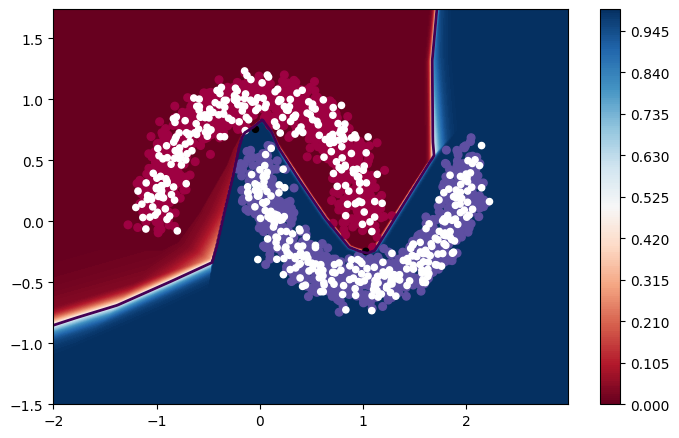

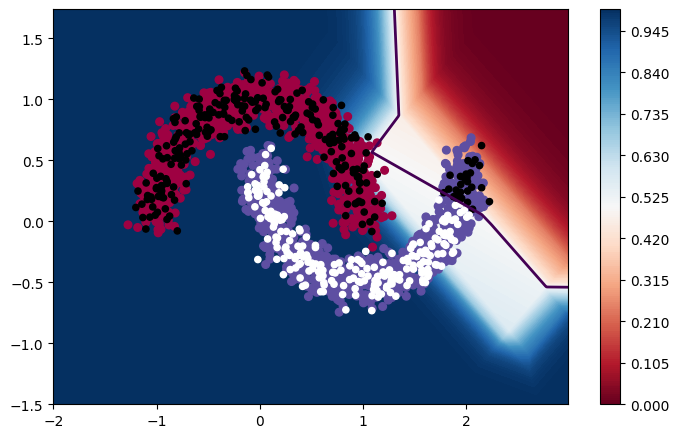

In [6]:
# SGD
net, optimizer = init(project_name="TwoMoons_binary", opt_name="SGD", batch_size=BATCH_SIZE, architecture="MLP", dataset_name="TwoMoons", lr=LR/3)

lr_decay_epochs = [15, 25]
for decay_epoch in lr_decay_epochs:
    if pre_epoch > decay_epoch:
        for param_group in optimizer.param_groups:
            param_group["lr"] *= 0.5

# Train
for epoch in range(pre_epoch, EPOCH):
    print("\nEpoch: %d" % (epoch + 1))
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0

    if epoch in lr_decay_epochs:
        for param_group in optimizer.param_groups:
            param_group["lr"] *= 0.5

    for i, data in enumerate(trainloader, 0):
        # prepare dataset
        length = len(trainloader)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # forward & backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        print(
            "[Epoch:%d, Iter:%d] Loss: %.03f | Acc: %.3f%% "
            % (
                epoch + 1,
                (i + 1 + (epoch) * length),
                sum_loss / (i + 1),
                100.0 * correct / total,
            )
        )
    print("Waiting Test...")
    with torch.no_grad():
        train_loss, train_acc = net.evaluate(trainloader, criterion, device, eval=False, qt=False)
        qtrain_loss, qtrain_acc = net.evaluate(trainloader, criterion, device, eval=False, qt=True)
        test_loss, test_acc=net.evaluate(testloader, criterion, device, eval=True, qt=False)
        qtest_loss, qtest_acc=net.evaluate(testloader, criterion, device, eval=True, qt=True)
        wandb.log(
            {
                "test_loss": test_loss,
                "quantized_test_loss": qtest_loss,
                "accuracy": train_acc,
                "quantized_accuracy": qtrain_acc,
                "test_accuracy": test_acc,
                "quantized_test_accuracy": qtest_acc
            }
        )
        print(
            "Train Loss: %.03f | Train Acc: %.3f%% | Test Loss: %.03f | Test Acc: %.3f%% "
            % (
                train_loss,
                train_acc,
                test_loss,
                test_acc,
            )
        )
        print(
            "Quantized Train Loss: %.03f | Quantized Train Acc: %.3f%% | Quantized Test Loss: %.03f | Quantized Test Acc: %.3f%% "
            % (
                qtrain_loss,
                qtrain_acc,
                qtest_loss,
                qtest_acc,
            )
        )
wandb.finish()
figure.moons_plotcontour(net, X_train, X_test, Y_train, Y_test, width=600, device=device,method="SGD (non-quantized)")
model_copy = copy.deepcopy(net)
for name, param in model_copy.named_parameters():
    if not name.endswith(".bias"):
        param.data = torch.sign(param.data)
figure.moons_plotcontour(model_copy, X_train, X_test, Y_train, Y_test, width=600, device=device, method="SGD (quantized)")


Epoch: 1
[Epoch:1, Iter:1] Loss: 0.670 | Acc: 50.000% 
[Epoch:1, Iter:2] Loss: 0.664 | Acc: 52.000% 
[Epoch:1, Iter:3] Loss: 0.641 | Acc: 58.667% 
[Epoch:1, Iter:4] Loss: 0.616 | Acc: 63.500% 
[Epoch:1, Iter:5] Loss: 0.580 | Acc: 68.000% 
[Epoch:1, Iter:6] Loss: 0.533 | Acc: 72.333% 
[Epoch:1, Iter:7] Loss: 0.518 | Acc: 74.000% 
[Epoch:1, Iter:8] Loss: 0.497 | Acc: 75.500% 
[Epoch:1, Iter:9] Loss: 0.476 | Acc: 77.111% 
[Epoch:1, Iter:10] Loss: 0.457 | Acc: 78.600% 
[Epoch:1, Iter:11] Loss: 0.440 | Acc: 79.273% 
[Epoch:1, Iter:12] Loss: 0.425 | Acc: 80.167% 
[Epoch:1, Iter:13] Loss: 0.408 | Acc: 81.077% 
[Epoch:1, Iter:14] Loss: 0.387 | Acc: 82.143% 
[Epoch:1, Iter:15] Loss: 0.383 | Acc: 82.533% 
[Epoch:1, Iter:16] Loss: 0.372 | Acc: 83.250% 
[Epoch:1, Iter:17] Loss: 0.363 | Acc: 84.000% 
[Epoch:1, Iter:18] Loss: 0.359 | Acc: 84.222% 
[Epoch:1, Iter:19] Loss: 0.345 | Acc: 84.737% 
[Epoch:1, Iter:20] Loss: 0.331 | Acc: 85.400% 
[Epoch:1, Iter:21] Loss: 0.321 | Acc: 85.810% 
[Epoch:1, It

accuracy,▇▇█▆█▁▇▇█▇██████▇█▇▇▇█████████████████▇█
quantized_accuracy,▁▅▅▅▆▆▄▄▄▄▅▅▆▆▆▇▇▇██████████████████████
quantized_test_accuracy,▁▅▅▅▆▆▄▄▄▄▅▅▆▆▆▇▇▇██████████████████████
quantized_test_loss,█▂▃▂▂▂▄▅▄▄▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▇▇█▅█▁▇▇████▇▇██████▇██████████████▇▇██▇
test_loss,▂▂▁▄▁█▂▂▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
accuracy,99.85001
quantized_accuracy,99.35001
quantized_test_accuracy,99.8
quantized_test_loss,0.00563
test_accuracy,99.8


c:\Users\lenovo\Desktop\CUHK\Research-2025\exp\quant_lib\figure.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(net(torch.tensor(X_test, dtype=torch.float, device=device)), 1), 1
c:\Users\lenovo\Desktop\CUHK\Research-2025\exp\quant_lib\figure.py:86: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(xx, yy, zz, levels=[0.5], color="k", linewidths=2)
c:\Users\lenovo\Desktop\CUHK\Research-2025\exp\quant_lib\figure.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(net(torch.tensor(X_test, dtype=torch.float, device=device)), 1), 1
c:\Users\lenovo\Desktop\CUHK\Research-2025\exp\quant_lib\figure.py:86: UserWarning: The following kwargs 

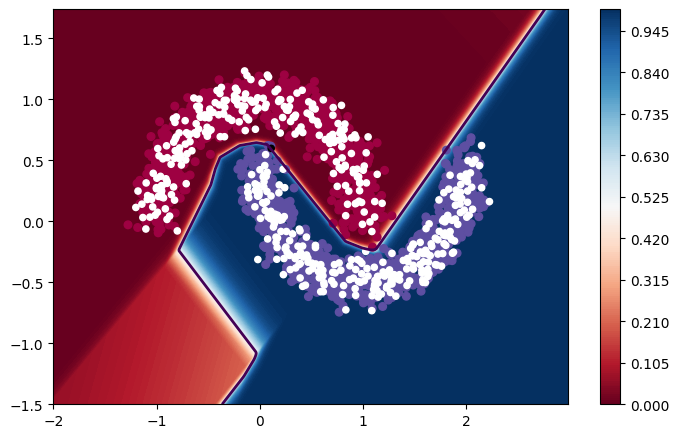

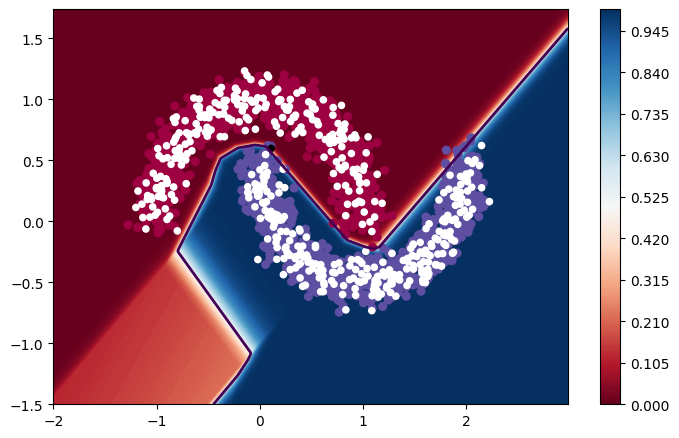

In [11]:
# ProxQuant
net, optimizer = init(project_name="TwoMoons_binary", opt_name="ProxQuant", batch_size=BATCH_SIZE, architecture="MLP", dataset_name="TwoMoons", lr=LR/10, reg_lambda=reg_lambda)

lr_decay_epochs = [15, 25]
lr=LR/10
for decay_epoch in lr_decay_epochs:
    if pre_epoch > decay_epoch:
        for param_group in optimizer.param_groups:
            param_group["lr"] *= 0.5
            lr*=0.5

# Train
it=-1
total_it=(EPOCH-ANNEAL_EPOCH_PQ)*len(trainloader)

for epoch in range(pre_epoch, EPOCH):
    print("\nEpoch: %d" % (epoch + 1))
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0

    if epoch in lr_decay_epochs:
        for param_group in optimizer.param_groups:
            param_group["lr"] *= 0.5
            lr*=0.5

    for i, data in enumerate(trainloader, 0):
        # prepare dataset
        if epoch < ANNEAL_EPOCH_PQ:
            epsilon=0
        else:
            it+=1
            epsilon = reg_lambda*it/total_it
        net.train()
        length = len(trainloader)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # forward & backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            for name, param in net.named_parameters():
                if not name.endswith(".bias"):
                    # Prox Step
                    param.data=(param.data+epsilon*torch.sign(param.data))/(1+epsilon)
        optimizer.zero_grad()
        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        print(
            "[Epoch:%d, Iter:%d] Loss: %.03f | Acc: %.3f%% "
            % (
                epoch + 1,
                (i + 1 + (epoch) * length),
                sum_loss / (i + 1),
                100.0 * correct / total,
            )
        )
    print("Waiting Test...")
    with torch.no_grad():
        train_loss, train_acc = net.evaluate(trainloader, criterion, device, eval=False, qt=False)
        qtrain_loss, qtrain_acc = net.evaluate(trainloader, criterion, device, eval=False, qt=True)
        test_loss, test_acc=net.evaluate(testloader, criterion, device, eval=True, qt=False)
        qtest_loss, qtest_acc=net.evaluate(testloader, criterion, device, eval=True, qt=True)
        wandb.log(
            {
                "test_loss": test_loss,
                "quantized_test_loss": qtest_loss,
                "accuracy": train_acc,
                "quantized_accuracy": qtrain_acc,
                "test_accuracy": test_acc,
                "quantized_test_accuracy": qtest_acc
            }
        )
        print(
            "Train Loss: %.03f | Train Acc: %.3f%% | Test Loss: %.03f | Test Acc: %.3f%% "
            % (
                train_loss,
                train_acc,
                test_loss,
                test_acc,
            )
        )
        print(
            "Quantized Train Loss: %.03f | Quantized Train Acc: %.3f%% | Quantized Test Loss: %.03f | Quantized Test Acc: %.3f%% "
            % (
                qtrain_loss,
                qtrain_acc,
                qtest_loss,
                qtest_acc,
            )
        )
wandb.finish()
figure.moons_plotcontour(net, X_train, X_test, Y_train, Y_test, width=600, device=device, method="ProxQuant (non-quantized)")
model_copy = copy.deepcopy(net)
for name, param in model_copy.named_parameters():
    if not name.endswith(".bias"):
        param.data = torch.sign(param.data)
figure.moons_plotcontour(model_copy, X_train, X_test, Y_train, Y_test, width=600, device=device, method="ProxQuant (quantized)")


Epoch: 1
[Epoch:1, Iter:1] Loss: 0.683 | Acc: 48.000% 
[Epoch:1, Iter:2] Loss: 0.720 | Acc: 52.000% 
[Epoch:1, Iter:3] Loss: 0.676 | Acc: 55.333% 
[Epoch:1, Iter:4] Loss: 0.658 | Acc: 61.500% 
[Epoch:1, Iter:5] Loss: 0.635 | Acc: 66.000% 
[Epoch:1, Iter:6] Loss: 0.604 | Acc: 69.667% 
[Epoch:1, Iter:7] Loss: 0.573 | Acc: 71.429% 
[Epoch:1, Iter:8] Loss: 0.537 | Acc: 73.250% 
[Epoch:1, Iter:9] Loss: 0.512 | Acc: 74.667% 
[Epoch:1, Iter:10] Loss: 0.512 | Acc: 75.400% 
[Epoch:1, Iter:11] Loss: 0.490 | Acc: 76.545% 
[Epoch:1, Iter:12] Loss: 0.460 | Acc: 78.167% 
[Epoch:1, Iter:13] Loss: 0.442 | Acc: 79.231% 
[Epoch:1, Iter:14] Loss: 0.423 | Acc: 80.286% 
[Epoch:1, Iter:15] Loss: 0.412 | Acc: 80.800% 
[Epoch:1, Iter:16] Loss: 0.402 | Acc: 81.500% 
[Epoch:1, Iter:17] Loss: 0.390 | Acc: 82.235% 
[Epoch:1, Iter:18] Loss: 0.379 | Acc: 82.778% 
[Epoch:1, Iter:19] Loss: 0.378 | Acc: 83.158% 
[Epoch:1, Iter:20] Loss: 0.363 | Acc: 83.700% 
[Epoch:1, Iter:21] Loss: 0.348 | Acc: 84.476% 
[Epoch:1, It

accuracy,▅▆▇▇█▁█▅█▆▇█████▆████████▇▇███████▇██▇██
quantized_accuracy,▂▇█▇▃▅▁▁▆▃▄▄▄▃▄▃▅▃▃▃▃▂▃▃▃▅▇▇▇▇▆▇▇█▇█████
quantized_test_accuracy,▃▇██▄▅▁▁▆▃▅▅▄▃▄▄▅▄▄▄▃▂▃▄▄▅▇▇█▇▇█████████
quantized_test_loss,▆▁▁▁▆▄▅█▂▄▃▄▃▄▄▄▂▄▄▄▄▅▄▄▄▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁
test_accuracy,▄▆▇██▁█▆█▄▇█████▆█▇██████▇██████▇█▆██▇█▇
test_loss,▆▄▂▂▁█▁▄▁▄▂▂▁▁▁▁▃▁▁▁▂▁▁▁▁▂▂▁▁▁▂▁▂▁▃▁▁▂▁▁
accuracy,99.85001
quantized_accuracy,99.75001
quantized_test_accuracy,99.60001
quantized_test_loss,0.00745
test_accuracy,99.60001


c:\Users\lenovo\Desktop\CUHK\Research-2025\exp\quant_lib\figure.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(net(torch.tensor(X_test, dtype=torch.float, device=device)), 1), 1
c:\Users\lenovo\Desktop\CUHK\Research-2025\exp\quant_lib\figure.py:86: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(xx, yy, zz, levels=[0.5], color="k", linewidths=2)
c:\Users\lenovo\Desktop\CUHK\Research-2025\exp\quant_lib\figure.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(net(torch.tensor(X_test, dtype=torch.float, device=device)), 1), 1
c:\Users\lenovo\Desktop\CUHK\Research-2025\exp\quant_lib\figure.py:86: UserWarning: The following kwargs 

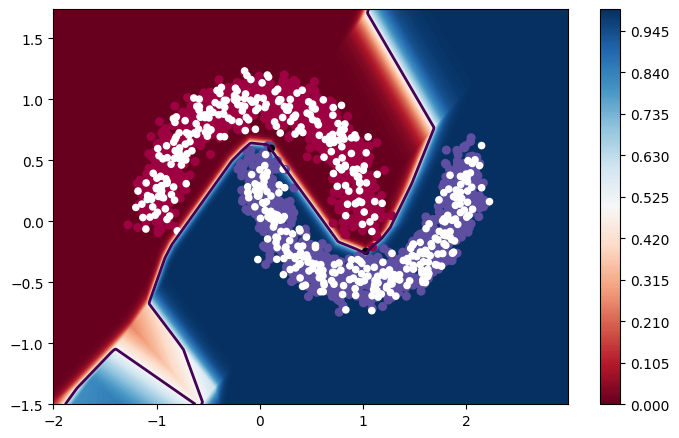

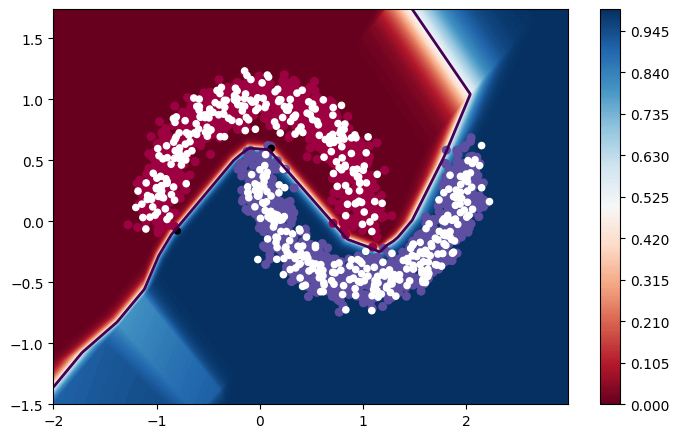

In [8]:
# ASkewSGD
net, optimizer = init(project_name="TwoMoons_binary", opt_name="ASkewSGD", batch_size=BATCH_SIZE, architecture="MLP", dataset_name="TwoMoons", lr=LR/3, alpha=alpha)

lr_decay_epochs = [15, 25]
for decay_epoch in lr_decay_epochs:
    if pre_epoch > decay_epoch:
        for param_group in optimizer.param_groups:
            param_group["lr"] *= 0.5

# Train

for epoch in range(pre_epoch, EPOCH):
    print("\nEpoch: %d" % (epoch + 1))
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0

    if epoch in lr_decay_epochs:
        for param_group in optimizer.param_groups:
            param_group["lr"] *= 0.5

    for i, data in enumerate(trainloader, 0):
        if epoch < ANNEAL_EPOCH_AS:
            epsilon=1
        else:
            epsilon =  DECAY_CONST ** ((epoch - ANNEAL_EPOCH_AS)+(i/len(trainloader)))
        # prepare dataset
        length = len(trainloader)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # forward & backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        for param_group in optimizer.param_groups:
            if param_group["tag"] == "weights":
                for idx, p in enumerate(param_group["params"]):
                    constr = epsilon - (p.data**2 - 1) ** 2
                    Kx = -4 * (p.data**2 - 1) * p.data
                    direct_grad = torch.logical_or(
                        torch.logical_or(constr >= 0, Kx == 0),
                        torch.logical_and(
                            constr < 0, (-Kx * p.grad.data) >= -alpha * constr
                        ),
                    )
                    p.grad.data[direct_grad] = p.grad.data[direct_grad]
                    p.grad.data[~direct_grad] = (torch.clip(
                        alpha * constr / Kx,
                        -1,
                        1,
                    ))[~direct_grad]
        optimizer.step()
        optimizer.zero_grad()
        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        print(
            "[Epoch:%d, Iter:%d] Loss: %.03f | Acc: %.3f%% "
            % (
                epoch + 1,
                (i + 1 + (epoch) * length),
                sum_loss / (i + 1),
                100.0 * correct / total,
            )
        )
    print("Waiting Test...")
    with torch.no_grad():
        train_loss, train_acc = net.evaluate(trainloader, criterion, device, eval=False, qt=False)
        qtrain_loss, qtrain_acc = net.evaluate(trainloader, criterion, device, eval=False, qt=True)
        test_loss, test_acc=net.evaluate(testloader, criterion, device, eval=True, qt=False)
        qtest_loss, qtest_acc=net.evaluate(testloader, criterion, device, eval=True, qt=True)
        wandb.log(
            {
                "test_loss": test_loss,
                "quantized_test_loss": qtest_loss,
                "accuracy": train_acc,
                "quantized_accuracy": qtrain_acc,
                "test_accuracy": test_acc,
                "quantized_test_accuracy": qtest_acc
            }
        )
        print(
            "Train Loss: %.03f | Train Acc: %.3f%% | Test Loss: %.03f | Test Acc: %.3f%% "
            % (
                train_loss,
                train_acc,
                test_loss,
                test_acc,
            )
        )
        print(
            "Quantized Train Loss: %.03f | Quantized Train Acc: %.3f%% | Quantized Test Loss: %.03f | Quantized Test Acc: %.3f%% "
            % (
                qtrain_loss,
                qtrain_acc,
                qtest_loss,
                qtest_acc,
            )
        )
wandb.finish()
figure.moons_plotcontour(net, X_train, X_test, Y_train, Y_test, width=600, device=device, method="ASkewSGD (non-quantized)")
model_copy = copy.deepcopy(net)
for name, param in model_copy.named_parameters():
    if not name.endswith(".bias"):
        param.data = torch.sign(param.data)
figure.moons_plotcontour(model_copy, X_train, X_test, Y_train, Y_test, width=600, device=device, method="ASkewSGD (quantized)")


Epoch: 1
[epoch:1, iter:1] Loss: 1.097 | Acc: 26.000% 
[epoch:1, iter:2] Loss: 0.846 | Acc: 33.000% 
[epoch:1, iter:3] Loss: 0.764 | Acc: 36.000% 
[epoch:1, iter:4] Loss: 0.695 | Acc: 39.500% 
[epoch:1, iter:5] Loss: 0.664 | Acc: 41.600% 
[epoch:1, iter:6] Loss: 0.640 | Acc: 43.333% 
[epoch:1, iter:7] Loss: 0.577 | Acc: 44.571% 
[epoch:1, iter:8] Loss: 0.566 | Acc: 45.250% 
[epoch:1, iter:9] Loss: 0.537 | Acc: 46.222% 
[epoch:1, iter:10] Loss: 0.536 | Acc: 45.600% 
[epoch:1, iter:11] Loss: 0.513 | Acc: 45.818% 
[epoch:1, iter:12] Loss: 0.520 | Acc: 46.500% 
[epoch:1, iter:13] Loss: 0.502 | Acc: 47.385% 
[epoch:1, iter:14] Loss: 0.491 | Acc: 46.571% 
[epoch:1, iter:15] Loss: 0.487 | Acc: 46.667% 
[epoch:1, iter:16] Loss: 0.482 | Acc: 47.375% 
[epoch:1, iter:17] Loss: 0.469 | Acc: 47.882% 
[epoch:1, iter:18] Loss: 0.459 | Acc: 48.111% 
[epoch:1, iter:19] Loss: 0.449 | Acc: 48.316% 
[epoch:1, iter:20] Loss: 0.446 | Acc: 48.900% 
[epoch:1, iter:21] Loss: 0.443 | Acc: 48.762% 
[epoch:1, it

accuracy,▁▁▆█▇█▇▃▇▃▅▄▃▄▅▆▆▅▅▅▅▄▅▅▄▅▄▆▆▅▄▃▄▄▄▄▄▄▄▅
quantized_accuracy,▄▅▅████▇██████████████████████████████▁█
quantized_test_accuracy,▅▆▆████▇██████████████████████████████▁█
quantized_test_loss,▅▄▃▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁
test_accuracy,▁▁▆█▇█▇▃▆▃▅▄▃▄▅▆▆▄▅▅▅▄▅▅▄▅▄▆▆▅▄▃▄▃▄▄▄▄▄▅
test_loss,▇▆▃▁▃▁▂█▂▆▄▄▅▅▄▃▃▅▄▄▄▄▄▄▄▄▅▃▄▄▅▇▆█▆▇▇▅▄▃
accuracy,76.35001
quantized_accuracy,99.60001
quantized_test_accuracy,100.00001
quantized_test_loss,0.01175
test_accuracy,78.60001


c:\Users\lenovo\Desktop\CUHK\Research-2025\exp\quant_lib\figure.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(net(torch.tensor(X_test, dtype=torch.float, device=device)), 1), 1
c:\Users\lenovo\Desktop\CUHK\Research-2025\exp\quant_lib\figure.py:86: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(xx, yy, zz, levels=[0.5], color="k", linewidths=2)
c:\Users\lenovo\Desktop\CUHK\Research-2025\exp\quant_lib\figure.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.softmax(net(torch.tensor(X_test, dtype=torch.float, device=device)), 1), 1
c:\Users\lenovo\Desktop\CUHK\Research-2025\exp\quant_lib\figure.py:86: UserWarning: The following kwargs 

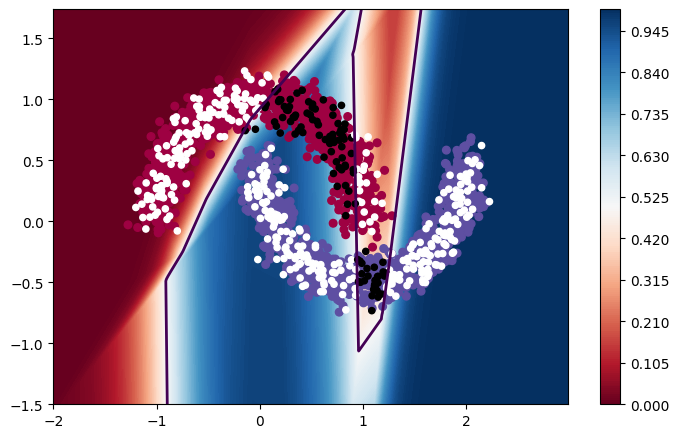

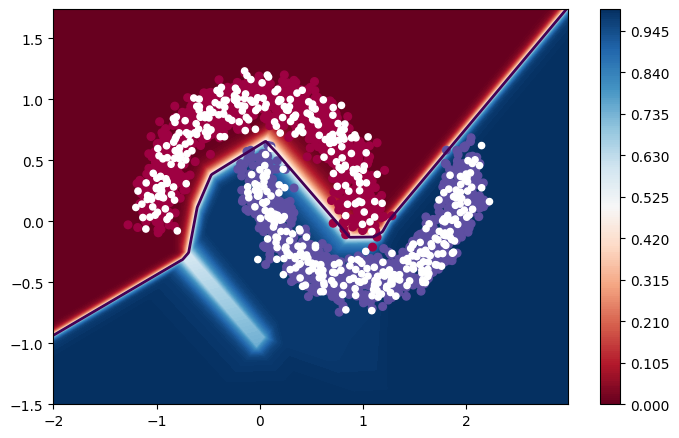

In [9]:
# Deterministic BinaryConnect
net, optimizer = init(project_name="TwoMoons_binary", opt_name="Deterministic BinaryConnect", batch_size=BATCH_SIZE, architecture="MLP", dataset_name="TwoMoons", lr=LR/10)

model_copy = copy.deepcopy(net)

lr_decay_epochs = [15, 25]
for decay_epoch in lr_decay_epochs:
    if pre_epoch > decay_epoch:
        for param_group in optimizer.param_groups:
            param_group["lr"] *= 0.5

# Train
for epoch in range(pre_epoch, EPOCH):
    print("\nEpoch: %d" % (epoch + 1))
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0

    if epoch in lr_decay_epochs:
        for param_group in optimizer.param_groups:
            param_group["lr"] *= 0.5

    for i, data in enumerate(trainloader, 0):
        # prepare dataset
        length = len(trainloader)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # forward & backward
        with torch.no_grad():
            outputs = net(inputs)
            loss2 = criterion(outputs, labels)
            for net_name, net_param in net.named_parameters():
                if not net_name.endswith(".bias"):
                    net_param.data=net.quantize(net_param.data, net.bit_width)
        outputs2 = net(inputs)
        loss = criterion(outputs2, labels)
        loss.backward()
        optimizer.step()
        for (net_name, net_param), (model_copy_name, model_copy_param) in zip(
            net.named_parameters(), model_copy.named_parameters()
        ):
            if not net_name.endswith(".bias"):
                delta = net_param.data - model_copy.quantize(model_copy_param.data, model_copy.bit_width)
                net_param.data = torch.clamp(model_copy_param.data + delta, -1, 1)
                model_copy_param.data = torch.clamp(model_copy_param.data + delta, -1, 1)
        sum_loss += loss.item()
        optimizer.zero_grad()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        print(
            "[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% "
            % (
                epoch + 1,
                (i + 1 + (epoch) * length),
                sum_loss / (i + 1),
                100.0 * correct / total,
            )
        )
    print("Waiting Test...")
    with torch.no_grad():
        train_loss, train_acc = net.evaluate(trainloader, criterion, device, eval=False, qt=False)
        qtrain_loss, qtrain_acc = net.evaluate(trainloader, criterion, device, eval=False, qt=True)
        test_loss, test_acc=net.evaluate(testloader, criterion, device, eval=True, qt=False)
        qtest_loss, qtest_acc=net.evaluate(testloader, criterion, device, eval=True, qt=True)
        wandb.log(
            {
                "test_loss": test_loss,
                "quantized_test_loss": qtest_loss,
                "accuracy": train_acc,
                "quantized_accuracy": qtrain_acc,
                "test_accuracy": test_acc,
                "quantized_test_accuracy": qtest_acc
            }
        )
        print(
            "Train Loss: %.03f | Train Acc: %.3f%% | Test Loss: %.03f | Test Acc: %.3f%% "
            % (
                train_loss,
                train_acc,
                test_loss,
                test_acc,
            )
        )
        print(
            "Quantized Train Loss: %.03f | Quantized Train Acc: %.3f%% | Quantized Test Loss: %.03f | Quantized Test Acc: %.3f%% "
            % (
                qtrain_loss,
                qtrain_acc,
                qtest_loss,
                qtest_acc,
            )
        )
wandb.finish()
figure.moons_plotcontour(net, X_train, X_test, Y_train, Y_test, width=600, device=device, method="Deterministic BinaryConnect (non-quantized)")
model_copy = copy.deepcopy(net)
for name, param in model_copy.named_parameters():
    if not name.endswith(".bias"):
        param.data = torch.sign(param.data)
figure.moons_plotcontour(model_copy, X_train, X_test, Y_train, Y_test, width=600, device=device, method="Deterministic BinaryConnect (quantized)")

In [10]:
# # Stochastic BinaryConnect
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="TwoMoons_MLP",
#     name="Stochastic BinaryConnect",
#     # track hyperparameters and run metadata
#     config={
#         "batch_size": 200,
#         "architecture": "MLP",
#         "dataset": "TwoMoons",
#         "lr": 0.166,
#     },
# )

# # Define neural network
# net = copy.deepcopy(base_net)
# model_copy = copy.deepcopy(net)
# model_copy.eval()

# # Define loss funtion & optimizer
# criterion = nn.CrossEntropyLoss()
# weights = [p for name, p in net.named_parameters() if 'bias' not in name]
# bias = [p for name, p in net.named_parameters() if 'bias' in name]
# parameters = [{"params": weights, "tag": "weights"}, {"params": bias, "tag": "bias"}]
# optimizer = optim.Adam(parameters, lr=LR/3, betas=(0.9, 0.999))
# lr_decay_epochs = [15, 25]
# for decay_epoch in lr_decay_epochs:
#     if pre_epoch > decay_epoch:
#         for param_group in optimizer.param_groups:
#             param_group["lr"] *= 0.5

# # Train
# for epoch in range(pre_epoch, EPOCH):
#     print("\nEpoch: %d" % (epoch + 1))
#     net.train()
#     sum_loss = 0.0
#     correct = 0.0
#     total = 0.0

#     if epoch in lr_decay_epochs:
#         for param_group in optimizer.param_groups:
#             param_group["lr"] *= 0.5

#     for i, data in enumerate(trainloader, 0):
#         # prepare dataset
#         length = len(trainloader)
#         inputs, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)
#         # forward & backward
#         with torch.no_grad():
#             for net_name, net_param in net.named_parameters():
#                 if not net_name.endswith(".bias"):
#                     net_param.data = (torch.bernoulli(F.hardsigmoid(net_param.data*3))-0.5)*2
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         wandb.log(
#             {
#                 "quantized loss": loss,
#             }
#         )
        
#         with torch.no_grad():
#             for param_group in optimizer.param_groups:
#                 if param_group["tag"] == "weights":
#                     for idx, p in enumerate(param_group["params"]):
#                         p.data = torch.fill(p, 0)
#         optimizer.step()

#         with torch.no_grad():
#             for (net_name, net_param), (model_copy_name, model_copy_param) in zip(net.named_parameters(), model_copy.named_parameters()):
#                 if not net_name.endswith(".bias"):
#                     delta = net_param.data
#                     net_param.data = model_copy_param.data + delta
#                 model_copy_param.data = net_param.data

#         optimizer.zero_grad()
#         sum_loss += loss.item()
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += predicted.eq(labels.data).cpu().sum()
#         print(
#             "[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% "
#             % (
#                 epoch + 1,
#                 (i + 1 + (epoch) * length),
#                 sum_loss / (i + 1),
#                 100.0 * correct / total,
#             )
#         )
#     print("Waiting Test...")
#     net_copy = copy.deepcopy(net)
#     with torch.no_grad():
#         for name, param in net_copy.named_parameters():
#             if not name.endswith(".bias"):
#                 param.data = (torch.bernoulli(F.hardsigmoid(param.data*3))-0.5)*2

#         correct = 0
#         total = 0
#         for data in testloader:
#             images, labels = data
#             images, labels = images.to(device), labels.to(device)
#             outputs = net_copy(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum()
#         print(
#             "Test's accuracy (after quantization) is: %.3f%%" % (100 * correct / total)
#         )
# wandb.finish()
# model_copy = copy.deepcopy(net)
# for name, param in model_copy.named_parameters():
#     if not name.endswith(".bias"):
#        param.data = (torch.bernoulli(F.hardsigmoid(param.data*3))-0.5)*2
# plotcontour(model_copy, X_train, X_test, Y_train, Y_test)